# Plan


In [1]:
# Ultimate goal: select a range of pixels, at various distances from isocenter, and plot the strength of the gradient field, minus the center frequency
# get a value of Hz/cm/tick for each of the gradients

# TODO:
# need to figure out a way to decently map the pixels to position from the images
# from the dicoms, extract the position and the RX of the image
# then select a bunch of pixels that have signal. heck could just use the whole image, based on a mask that shows where there is signal or there is not

# then for each pixel, get the position away from isocenter, and place on a plot the supposed gradient strength
# then fit a line to that, and get the gradient strength per tick


## Load the Tool

In [2]:
import argparse
import json
import signal
import subprocess
import sys
import matplotlib.pyplot as plt

In [3]:

sys.path.append('..')

# if tool is not defined name in the namespace
if "tool" in locals():
    tool.exsiInstance.stop()
    del tool

# print out the current path

from shimTool.Tool import Tool
from shimTool.dicomUtils import *
from shimTool.shimCompute import *

def load_config(filename):
    with open(filename, "r") as file:
        return json.load(file)

config = load_config("/home/heartvista/Documents/robert/ge3t_shim_tool/config.json")
tool = Tool(config, debugging=True)
#tool.exsiInstance.defaultCoil = "Head 24"


/home/heartvista/Documents/robert/ge3t_shim_tool/logs/scannerLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/arduinoLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/guiLog.txt
Debug: Failed to open serial port: [Errno 2] could not open port /dev/ttyACM1: [Errno 2] No such file or directory: '/dev/ttyACM1'
Debug SHIM CLIENT: Failed to start reading thread. Serial port is not open
INFO EXSI CLIENT: Socket connected
EXSI CLIENT DEBUG: Processing command:  ConnectToScanner product=newHV passwd=rTpAtD
EXSI CLIENT DEBUG: Processing command: 

 NotifyEvent all=on
EXSI CLIENT DEBUG: Processing command:  GetExamInfo
EXSI CLIENT DEBUG: Processing command:  LoadProtocol site path="ConformalShimCalibration4"
EXSI CLIENT DEBUG: Task keys found in message:  [4]
EXSI CLIENT DEBUG: Processing command:  SelectTask taskkey=4
EXSI CLIENT DEBUG: Processing command:  SetRxGeometry plane=axial
EXSI CLIENT DEBUG: Processing command:  SetGrxSlices center=0.0,0.0,None phaseNormal=10,0,0 freqNormal=0,0,10
EXSI CLIENT DEBUG: Command SetGrxSlices center=0.0,0.0,None phaseNormal=10,0,0 freqNormal=0,0,10 failed, clearing command queue.
EXSI CLIENT DEBUG: Clearing command: ActivateTask
EXSI CLIENT DEBUG: Clearing command: PatientTable advanceToScan
EXSI CLIENT DEBUG: Clearing command: Scan
SHIM CLIENT Debug: Clearing command: C
EXSI CLIENT DEBUG: Images are ready. in msg: <exsi-srv:27674:4847<NotifyEvent recon=done, 128 images available. taskKey=7 
EXSI CLIENT DEBUG: setting images_ready_event
EXSI CLIENT DEBUG: Images are ready. in msg: <exsi-srv:

## Run a calibration sequence and then a fieldmap scan to get the background
I.e. make sure that autoprescan is on

In [4]:
tool.doCalibrationScan()
tool.doFieldmapScan()

plane is None, center is None
EXSI CLIENT DEBUG: no matches for bed position.
plane is coronal, center is [0.0, 0.0, None]
20:22:57 SHIM TOOL: Initiating transfer using rsync.
20:22:57 SHIM TOOL: obtained exam data path: /export/home1/sdc_image_pool/images/p2/e2007


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

### show the resulting fieldmap and plot a scatter plot for each direction, gradient strength vs position to make sure that it is relatively flat...

In [5]:
def extractPixelSize(firstDCM):
    dcm = pydicom.dcmread(firstDCM)
    # Extract X and Y pixel size from PixelSpacing
    if 'PixelSpacing' in dcm:
        pixel_spacing = dcm.PixelSpacing
        pixel_size_x, pixel_size_y = pixel_spacing
    else:
        raise ValueError("Pixel Spacing information is not available in this DICOM file.")
    
    # Extract Z pixel size from SpacingBetweenSlices or SliceThickness
    if 'SpacingBetweenSlices' in dcm:
        pixel_size_z = dcm.SpacingBetweenSlices
    elif 'SliceThickness' in dcm:
        pixel_size_z = dcm.SliceThickness
    else:
        raise ValueError("Z spacing information is not available in this DICOM file.")
    
    return [pixel_size_x, pixel_size_y, pixel_size_z]
    
def computeFieldmapFromLatestFieldmapScan(tool: Tool)->np.ndarray:
    b0maps = compute_b0maps(1, tool.localExamRootDir)
    return b0maps[0]

def computeFieldmapFromFirstSeriesName(n, localExamRootDir, threshFactor=0.4) -> List[np.ndarray]:
    # computes the fieldmap from n scans ago
    """Computes the last n b0maps from pairs"""
    n = n+1
    seriesPaths = listSubDirs(localExamRootDir)
    print(f"DEBUG: Found {len(seriesPaths)} seriesPaths")
    if n == 1:
        seriesPaths = seriesPaths[-2*n:]
    else:
        seriesPaths = seriesPaths[-n * 2 : - (n - 1) * 2]
    b0maps = []
    for i in range(0, 2, 2):
        phase1, te1, name1 = extractComplexImageData(seriesPaths[i], threshFactor=threshFactor)
        print(f"DEBUG: Extracted te1 {te1}, name1 {name1}")
        phase2, te2, name2 = extractComplexImageData(seriesPaths[i + 1], threshFactor=threshFactor)
        print(f"DEBUG: Extracted te2 {te2}, name2 {name2}")
        b0map = compute_b0map(phase1, phase2, te1, te2)
        b0maps.append(b0map)
    return b0maps[0]

def plotPixelFieldStrengthsVsPosition(fig, title, points, xlabel, ylabel, xlim, ylim):
    fig.scatter(points[:,0], points[:,1])
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
    fig.set_xlim(xlim)
    fig.set_ylim(ylim)

def getFieldStrengthPoints(fieldmap, pixelSize, title=None):
    """
    for each dimensional direction:
        - collapse all strengths onto one dimension
        - compute the relative distance for each pixel position using pixelSize
        - create list of points (distanceFromIsocenter, fieldStrength)
        - plot the points
        - plot a line of best fit
    """
    points = [[],[],[]]
    # i want to take every non nan pixel value in the fieldmap
    # then for each pixel, get the distance from isocenter, and the field strength and add to points list
    def get_distances(pos):
        shape = fieldmap.shape
        ret = []
        for i in range(3):
            ret.append((pos[i] - (shape[i]/2+.5)) * pixelSize[i])
        return ret

    maxDist=0
    for y in range(fieldmap.shape[0]):
        for z in range(fieldmap.shape[1]):
            for x in range(fieldmap.shape[2]):
                if not np.isnan(fieldmap[y,z,x]):
                    fieldStrength = fieldmap[y,z,x]
                    distances = get_distances([y,z,x])
                    maxDist = max(maxDist, np.max(np.abs(distances)))
                    for i in range(3):
                        points[i].append([distances[i], fieldStrength])

    if title is not None:
        directions = ["Y", "Z", "X"]
        absheight=0
        for i in range(3):
            points[i] = np.array(points[i])
            absheight = max(absheight, np.nanmax(np.abs(points[i][:,1])))

        fig, axs = plt.subplots(3, 1, figsize=(10, 30))
        for i in range(3):
            plotPixelFieldStrengthsVsPosition(
                axs[i], 
                f"{title} Field (Hz) vs Distance (mm) Isocenter in {directions[i]}", 
                points[i], 
                "Distance from Isocenter (mm)", 
                "Field Strength (Hz)", 
                [-maxDist, maxDist], 
                [-absheight, absheight]
            )
        plt.show()
    return [points[2], points[0], points[1]]


In [6]:
seriesPaths = listSubDirs(tool.localExamRootDir)
seriesPaths = seriesPaths[-1 * 2 :]
print(seriesPaths)

['/home/heartvista/Documents/robert/ge3t_shim_tool/data/52665/s28044', '/home/heartvista/Documents/robert/ge3t_shim_tool/data/52665/s28045']


In [7]:
latestDCMDir = listSubDirs(tool.localExamRootDir)[-1]
firstDCM = listDicomFiles(latestDCMDir)[0]
# series = ['/home/heartvista/Documents/robert/ge3t_shim_tool/data/52660/s27812', '/home/heartvista/Documents/robert/ge3t_shim_tool/data/52660/s27813']
# firstDCM = listDicomFiles(series[1])[0]

pixelSize = extractPixelSize(firstDCM)
background = computeFieldmapFromLatestFieldmapScan(tool)
backgroundPoints = getFieldStrengthPoints(background, pixelSize)


DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd


## Need to figure out how to modify one gradient strength and take a second fieldmap.


In [ ]:
# tool.setLinGradients([50, 0, 0])
# tool.doFieldmapScan()
fieldmapx = computeFieldmapFromFirstSeriesName(2, tool.localExamRootDir)
fieldmapx = fieldmapx - background

xgradPoints = getFieldStrengthPoints(fieldmapx, pixelSize, "X Grad 50")[0]

# tool.setLinGradients([0, 50, 0])
# tool.doFieldmapScan()
fieldmapy = computeFieldmapFromFirstSeriesName(1, tool.localExamRootDir)
fieldmapy = fieldmapy - background

ygradPoints = getFieldStrengthPoints(fieldmapy, pixelSize, "Y Grad 50")[1]

# tool.setLinGradients([0, 0, 50])
# tool.doFieldmapScan()
fieldmapz = computeFieldmapFromFirstSeriesName(0, tool.localExamRootDir)
fieldmapz = fieldmapz - background

zgradPoints = getFieldStrengthPoints(fieldmapz, pixelSize, "Z Grad 50")[2]

## now fit a line to each of them and get the slope, for 50 grad in this case...

In [ ]:
points = [xgradPoints, ygradPoints, zgradPoints]

for i in range(3):
    # get the slope of the line of best fit
    points[i] = np.array(points[i])
    x = points[i][:,0]
    y = points[i][:,1]
    m, b = np.polyfit(x, y, 1)
    label = ["X", "Y", "Z"]
    print(f"Gradient {label[i]} with ticks set to 50: {m} Hz/mm ")
    print(f"\tGradient {label[i]}: {m/50} Hz/mm/tick")
    

## Write code to automate:
### For each gradient direction:
1. iterate through gradient strengths of -100 to 100
2. compute the Hz/mm/tick for each setting

### then get some statistics on the performance of the gradient

In [8]:
gradientTicksfine = list(range(-20,0,4)) + list(range(4,21,4))
gradientTicks = list(range(-80,0,20)) + gradientTicksfine + list(range(20,81,20))
gradientPoints = []
for i in range(3):
    slopes = []
    gradientToSet = [0,0,0]
    for ticks in gradientTicks:
        label = ["X", "Y", "Z"]
        print(f"Doing gradient {label[i]} with ticks set to {ticks}")
        gradientToSet[i] = ticks
        tool.exsiInstance.sendSetCenterPosition(None, [0,0,0])
        tool.setLinGradients(gradientToSet)
        tool.doFieldmapScan()
        fieldmap = computeFieldmapFromLatestFieldmapScan(tool)
        fieldmap = fieldmap - background
        points = np.array(getFieldStrengthPoints(fieldmap, pixelSize)[i])
        x = points[:,0]
        y = points[:,1]
        m, b = np.polyfit(x, y, 1)
        print(f"Gradient {label[i]} with ticks set to {ticks}: {m} Hz/mm ")
        print(f"\tGradient {label[i]}: {m/ticks} Hz/mm/tick")
        print("--------------------------------------------------------------")
        slopes.append([ticks, m/ticks])
    gradientPoints.append(slopes)


Doing gradient X with ticks set to -80
plane is None, center is [0, 0, 0]
plane is coronal, center is [0, 0, 0]
12:28:15 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:28:15 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is [0, 0, 0]
plane is coronal, center is [0, 0, 0]
plane is None, center is [0, 0, 0]
plane is coronal, center is [0, 0, 0]
12:28:43 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:28:43 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:29:08 SHIM TOOL: Done. 2 scans completed!
12:29:08 SHIM TOOL: Initiating transfer using rsync.
12:29:09 SHIM TOOL: Initiating transfer using rsync.
12:29:09 SHIM TOOL: evaluating map 0
12:29:09 SHIM TOOL: finished setting the per slice stats for map 0
12:29:09 SHIM TOOL: finished setting the volume stats for map 0
12:29:09 SHIM TOOL: evaluating map 1
12:29:09 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, na

In [11]:
for i in range(3):
    gradientPoints[i] = np.array(gradientPoints[i])
    ms = gradientPoints[i][:,1]
    for point in gradientPoints[i]:
        print(point)
print(f"Average gradient strength per tick: {np.mean(allStrengths)} Hz/mm/tick, \n\twith stdDev = {np.std(allStrengths)}, \n\tand median = {np.median(allStrengths)}")


[-8.00000000e+01  4.54241806e-02]
[-6.00000000e+01  4.51809021e-02]
[-40.           0.04574269]
[-20.           0.04577957]
[20.          0.04587911]
[40.          0.04416602]
[6.00000000e+01 4.58083224e-02]
[8.00000000e+01 4.44536384e-02]
[-8.00000000e+01  4.66397153e-02]
[-6.00000000e+01  4.71197614e-02]
[-40.           0.04339465]
[-20.           0.04557769]
[20.          0.04540434]
[40.          0.04518419]
[6.0000000e+01 4.6545151e-02]
[8.00000000e+01 4.63374969e-02]
[-8.00000000e+01  4.58999249e-02]
[-6.0000000e+01  4.5748447e-02]
[-40.           0.04537336]
[-20.           0.04618191]
[20.          0.04545761]
[4.00000000e+01 4.00730307e-03]
[6.00000000e+01 1.68216781e-02]
[8.00000000e+01 2.38430996e-02]
Average gradient strength per tick: 0.04174878153359385 Hz/mm/tick, 
	with stdDev = 0.01058638686220001, 
	and median = 0.045517650045785146


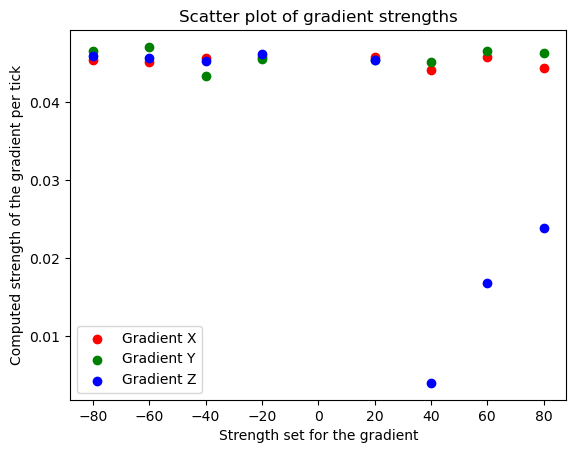

In [10]:
# plot the points from each gradient direction as a scatter plot with different colors. 
# on the x axis should be the strength set for the gradient, on the y axis should be the computed strength of the gradient per tick
# plot all three sets on the same graph

import matplotlib.pyplot as plt

# Plot the points from each gradient direction as a scatter plot with different colors
plt.scatter(gradientPoints[0][:, 0], gradientPoints[0][:, 1], color='red', label='Gradient X')
plt.scatter(gradientPoints[1][:, 0], gradientPoints[1][:, 1], color='green', label='Gradient Y')
plt.scatter(gradientPoints[2][:, 0], gradientPoints[2][:, 1], color='blue', label='Gradient Z')

# Set labels and title
plt.xlabel('Strength set for the gradient (Hz/mm/tick)')
plt.ylabel('Gradient Strength Applied (ticks)')
plt.title('Observed gradient strength granularity')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
gradientPoints = []
count = 29
print(tool.localExamRootDir)
for i in range(3):
    slopes = []
    gradientToSet = [0,0,0]
    for ticks in gradientTicks:
        label = ["X", "Y", "Z"]
        print(f"Doing gradient {label[i]} with ticks set to {ticks}")
        gradientToSet[i] = ticks
        fieldmap = computeFieldmapFromFirstSeriesName(count, tool.localExamRootDir)
        count = count - 1
        fieldmap = fieldmap - background
        points = np.array(getFieldStrengthPoints(fieldmap, pixelSize)[i])
        x = points[:,0]
        y = points[:,1]
        m, b = np.polyfit(x, y, 1)
        print(f"Gradient {label[i]} with ticks set to {ticks}: {m} Hz/mm ")
        print(f"\tGradient {label[i]}: {m/ticks} Hz/mm/tick")
        slopes.append([ticks, m/ticks])
    gradientPoints.append(slopes)
